# Sloan Digital Sky Survey Classification
## Classification of Galaxies, Stars and Quasars based on the D15 from the SDSS

### Importing Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

## Data Acquisition

### Default Query

**SELECT TOP 10000** <br/>
p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z, p.run, p.rerun, p.camcol, p.field,  <br/>
s.specobjid, s.class, s.z as redshift, s.plate, s.mjd, s.fiberid  <br/>
**FROM** PhotoObj **AS** p <br/>
   **JOIN** SpecObj **AS** s **ON** s.bestobjid = p.objid <br/>
**WHERE** <br/>
   p.u **BETWEEN** 0 **AND** 19.6 <br/>
   **AND** g **BETWEEN** 0 **AND** 20 <br/>



The above query joins two tables (actually views): The image table (PhotoObj) which contains all image objects and the spectral table (SpecObj) which contains corresponding spectral data. 

### Feature Description

In [35]:
sdss_df = pd.read_csv('input/SDSS_dr16.csv', skiprows=0)
# sdss_df = pd.read_csv('input/SDSS_top.csv', skiprows=0)

## Data Exploration

### Basic stats about our dataset

Let's take a first look at our dataset to see what we're working with!

In [36]:
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,185.182780,1.189488,19.34126,18.46700,18.44940,18.33074,18.06268,756,301,6,463,4.330450e+18,QSO,2.627589,3846,55327,865
1,1.237650e+18,216.927113,0.824043,19.20285,18.19531,17.59929,17.22163,17.02410,756,301,5,675,3.446170e+17,GALAXY,0.150541,306,51637,335
2,1.237651e+18,130.183176,49.955453,18.53200,17.65095,17.24701,17.12667,17.10159,1331,301,2,175,8.231498e+18,STAR,-0.000139,7311,57038,158
3,1.237650e+18,146.011531,59.079110,18.68013,18.36549,18.32169,18.33179,18.27370,1331,301,4,261,5.100870e+17,QSO,0.775121,453,51915,196
4,1.237660e+18,190.489753,63.544891,19.15626,18.12416,17.64571,17.40442,17.13662,2304,301,6,214,8.794520e+17,QSO,2.613389,781,52373,450


We can tell that we have all the features as described in the above query. 

We notice that there are no categorical features at all - besides the class column. As some machine learning models can't handle categorical feature columns at all, we will encode this column to be a numerical column later on.

Let's find out about the types of columns we have:

In [37]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      30000 non-null  float64
 1   ra         30000 non-null  float64
 2   dec        30000 non-null  float64
 3   u          30000 non-null  float64
 4   g          30000 non-null  float64
 5   r          30000 non-null  float64
 6   i          30000 non-null  float64
 7   z          30000 non-null  float64
 8   run        30000 non-null  int64  
 9   rerun      30000 non-null  int64  
 10  camcol     30000 non-null  int64  
 11  field      30000 non-null  int64  
 12  specobjid  30000 non-null  float64
 13  class      30000 non-null  object 
 14  redshift   30000 non-null  float64
 15  plate      30000 non-null  int64  
 16  mjd        30000 non-null  int64  
 17  fiberid    30000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 4.1+ MB


The dataset has 10000 examples, 17 feature columns and 1 target column. 8 of the 17 features are 64 bit integers, 1 feature is an unsigned 64 bit integer, 8 are 64 bit floats and the target column is of the type object. 

In [38]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.00000,30000.000000,30000.000000
mean,1.237650e+18,169.220255,18.833856,18.693241,17.721518,17.299627,17.083654,16.952933,1173.076633,301.0,3.565333,286.052433,1.863896e+18,0.433206,1655.38800,53026.506633,343.559367
std,1.285415e+12,67.342191,26.489236,0.799212,1.071583,1.256390,1.336041,1.406907,412.550959,0.0,1.584450,192.647294,2.397609e+18,0.704016,2129.48962,1666.154163,215.758118
min,1.237646e+18,0.039086,-11.214592,12.421390,12.357220,11.633850,11.051390,10.616260,94.000000,301.0,1.000000,11.000000,2.994900e+17,-0.004268,266.00000,51578.000000,1.000000
25%,1.237650e+18,134.683454,-0.425347,18.297902,17.066893,16.430835,16.115680,15.905575,756.000000,301.0,2.000000,129.000000,3.817382e+17,0.000140,339.00000,51909.000000,164.000000
50%,1.237650e+18,175.103945,1.044443,18.926905,17.803380,17.306280,17.045095,16.907735,1239.000000,301.0,4.000000,253.000000,5.890115e+17,0.073726,523.00000,52056.000000,329.000000
75%,1.237650e+18,213.058163,48.587442,19.299202,18.538702,18.335195,18.225887,18.140358,1350.000000,301.0,5.000000,417.000000,2.881224e+18,0.668148,2559.00000,54454.000000,505.000000
max,1.237660e+18,359.996095,68.723470,19.599860,19.918970,29.744050,27.227860,28.234510,2328.000000,301.0,6.000000,812.000000,1.312126e+19,6.990327,11654.00000,58543.000000,1000.000000


From the above table we can tell that are no missing values at all. This means: **no imputing!**

We also notice that most of the features stay within a reasonable scale when comparing values within **only one** column. We can recognize this from the min, max and quartil rows.

In [39]:
sdss_df['class'].value_counts()

QSO       10000
GALAXY    10000
STAR      10000
Name: class, dtype: int64

The most objects (50%) are galaxies, a little less (40%) are stars and only around (10%) of the rows are classified as QSOs.

### First Data Filtering

In [40]:
sdss_df.columns.values

array(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun',
       'camcol', 'field', 'specobjid', 'class', 'redshift', 'plate',
       'mjd', 'fiberid'], dtype=object)

There is no need to know everything about stars, galaxy or quasars - yet we can already tell which features are **unlikely** to be related to the target variable 'class'.

**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.

Even more: The features 'run', 'rerun', 'camcol' and 'field' are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.


In [41]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,185.18278,1.189488,19.34126,18.467,18.4494,18.33074,18.06268,QSO,2.627589,3846,55327,865


### Univariate Analysis

#### Redshift

To start the univariate analysis we will plot histograms for the 'redshift' feature column for each class.

This will tell us how the redshift values are distributed over their range.

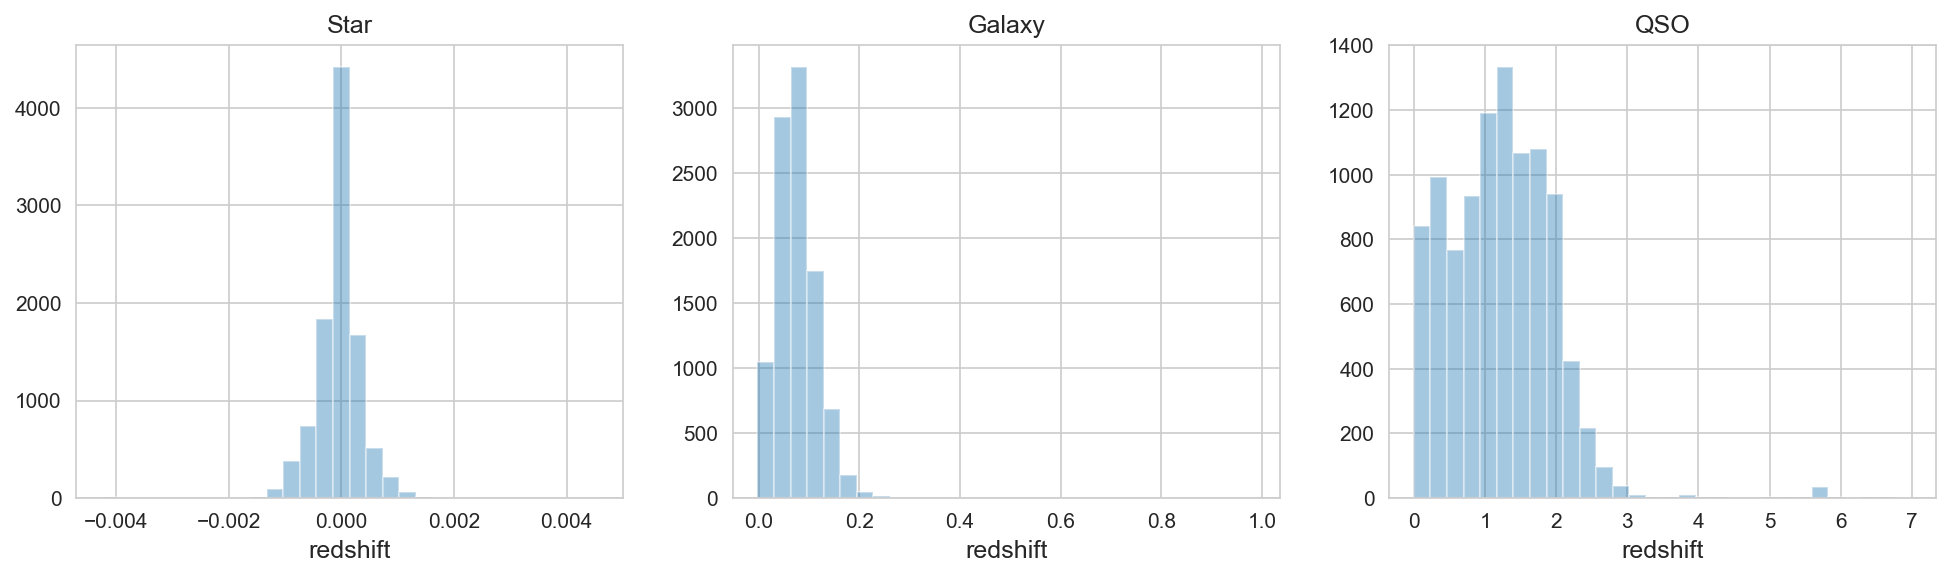

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

This is an interesting result.

We can cleary tell that the redshift values for the classes quite differ. 

* **Star:** The histogram looks like a truncated zero-centered normal distribution.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers.


Hence the distplot tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far.  

As we can distinct the classes from each other just based on this column - 'redshift' is very likely to be helping a lot classifying new objects.

#### dec

Let's lvplot the values of dec (Recall: position on celestial equator)!

Text(0.5, 1.0, 'dec')

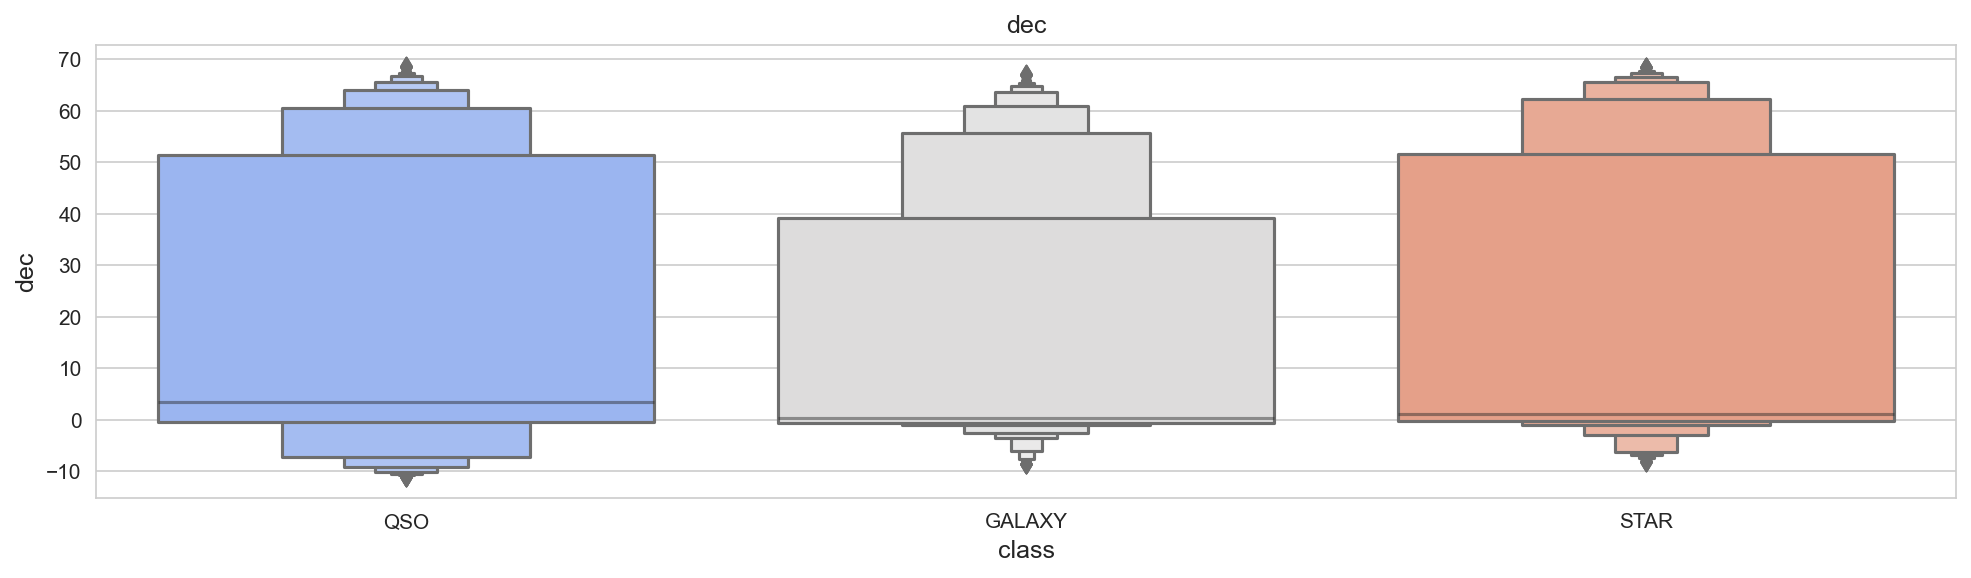

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=sdss_df['class'], y=sdss_df['dec'], palette='coolwarm')
ax.set_title('dec')


The Letter value (LV) Plot show us an estimate of the distribution of the data. It shows boxes which relate to the amount of values within the range of values inside the box.

In this case we can observe a clear distinction between Stars and the other two classes. The difference between Galaxies and Quasars is smaller.


### Multivariate Analysis

#### u,g,r,i,z filters

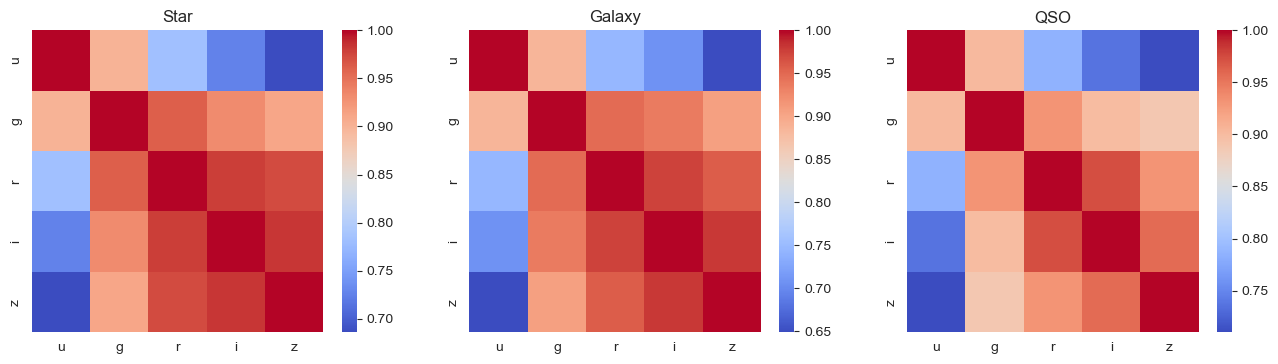

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(sdss_df[sdss_df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(sdss_df[sdss_df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(sdss_df[sdss_df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

Right of the top we observe that the correlation matrices look very similiar for every class.(point note)

We can tell that there are high correlations between the different bands. This feels not really suprising - intuitively one would think that if one of the bands captures some object, the other bands should capture something aswell.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

**But:** as we can see - the correlation is roughly the same for every class...the different bands behave the same for the different classes!

#### Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class 

Text(0.5, 1.0, 'Equatorial coordinates')

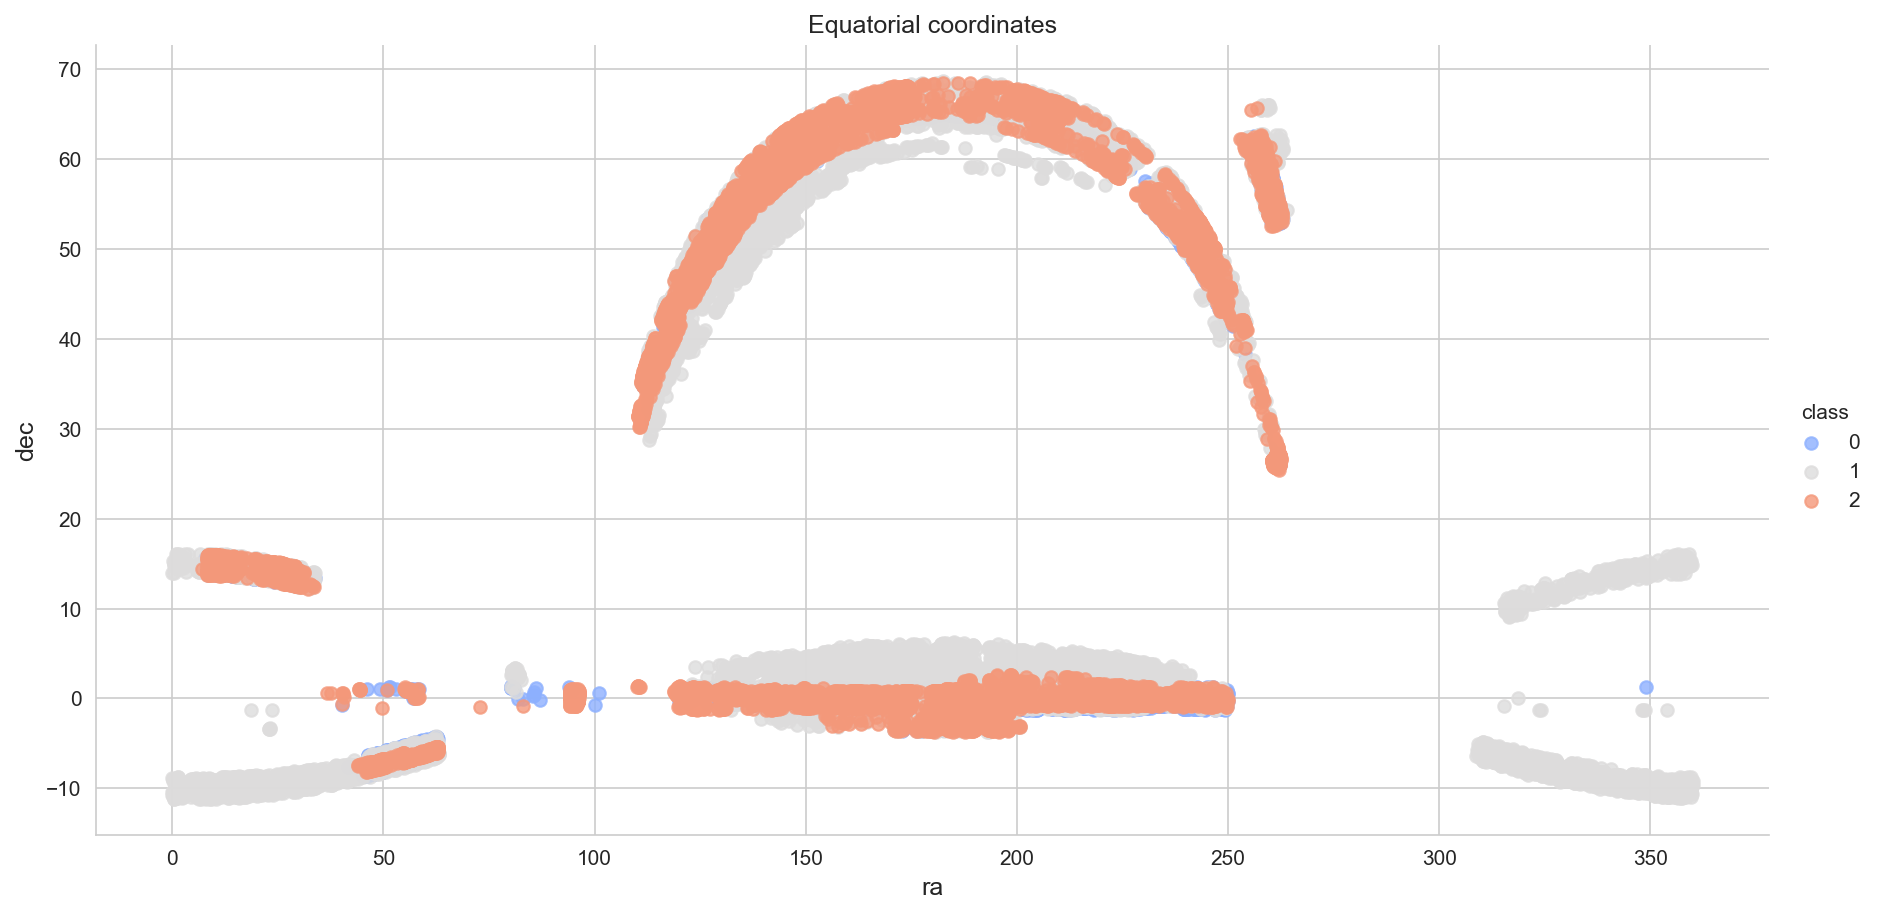

In [67]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', height=6, aspect=2)
plt.title('Equatorial coordinates')

## Feature Engineering

### u, g, r, i, z

In [130]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=1)
ugriz = pca.fit_transform(sdss_df_fe[[ 'g', 'r']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1'}, axis=1, inplace = True)
sdss_df_fe.drop(['g', 'r'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,u,i,z,class,redshift,plate,mjd,fiberid,PCA_1
0,185.182780,1.189488,19.34126,18.33074,18.06268,1,2.627589,3846,55327,865,1.359070
1,216.927113,0.824043,19.20285,17.22163,17.02410,0,0.150541,306,51637,335,0.534983
2,130.183176,49.955453,18.53200,17.12667,17.10159,2,-0.000139,7311,57038,158,-0.085771
3,146.011531,59.079110,18.68013,18.33179,18.27370,1,0.775121,453,51915,196,1.196014
4,190.489753,63.544891,19.15626,17.40442,17.13662,1,2.613389,781,52373,450,0.524369


In [131]:
# sdss_df_fe = sdss_df
# sdss_df_fe.head()

## Machine Learning Models - Training

#### Feature Scaling

In [132]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

In [133]:
X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

#### K Nearest Neighbors

In [134]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 90.87
Time consumed for training: 0.112 seconds
Time consumed for prediction: 0.84196 seconds


#### Naive Bayes

In [135]:
from sklearn.preprocessing import MaxAbsScaler
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(sdss_df_fe.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 96.06
Time consumed for training: 0.010 seconds
Time consumed for prediction: 0.00324 seconds


#### XGBoost

In [136]:
xgb = XGBClassifier(n_estimators=100, eval_metric='mlogloss')
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 98.78
Time consumed for training: 4.572
Time consumed for prediction: 0.02434 seconds


#### Scitkit-Learn's Random Forest Classifier

In [137]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 98.39
Time consumed for training: 0.487 seconds
Time consumed for prediction: 0.01243 seconds


#### Support Vector Machine Classifier

In [138]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 92.98
Time consumed for training: 6.704 seconds
Time consumed for prediction: 6.38332 seconds


Let's compare the results. We will create a table for a more comprehensive overview.

In [139]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Score': [acc_knn, acc_gnb, acc_xgb, acc_rfc, acc_svc],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
XGBoost,98.777778,4.571946,0.024344
Random Forest,98.393939,0.486958,0.012434
Naive Bayes,96.060606,0.009764,0.003245
SVC,92.979798,6.703524,6.383319
KNN,90.868687,0.111547,0.841959


We can see that both XGBoost and Scikit-Learn's Random Forest Classifier could achieve very high accuracy.

Gaussian Naive Bayes achieves just a little less accuracy but needs a very little amount of time to both train and predict data.

KNN performs about 5% worse than Naive Bayes.

The Support Vector Machine Classifier has the worst accuracy, plus takes the most of time for its operations.

### K Fold Cross Validation

We will no perform k fold cross valdiation for the top 2 classifiers, i.e. XGBoost & Random Forest.

We do this to get a more realistic result by testing the performance for 10 different train and test datasets and averaging the results. 

Cross validation ensures that the above result is not arbitary and gives a more reliable performance check.

#### Scikit-Learn's Random Forest Classifier

In [140]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.98358209 0.98258706 0.98756219 0.98706468 0.98656716 0.98855721
 0.98457711 0.97960199 0.98606965 0.98756219]
Mean: 0.9853731343283583
Standard Deviation: 0.002634468118382832


#### XGBoost

In [141]:
xgb_cv = XGBClassifier(n_estimators=100, eval_metric='mlogloss')
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99104478 0.98656716 0.98905473 0.99054726 0.99104478 0.98905473
 0.98706468 0.98358209 0.99054726 0.9920398 ]
Mean: 0.9890547263681592
Standard Deviation: 0.002477591959798755


Cross validating the models showed that the accuracy values were in fact not arbitary and proofed that both models are performing very well. 

XGBoost showed a higher mean and lower standard deviation than the Scikit-Learn RFC.

A high mean corresponds to a more stable performance and a low standard deviation corresponds to smaller range of results. 

### Feature Importance

Decision Trees have the unique property of being able to order features by their ability to split between the classes.

We will now visualize the features and their splitting ability.

In [142]:
importances = pd.DataFrame({
    'Feature': sdss_df_fe.drop('class', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
redshift,0.583745
plate,0.211842
i,0.093233
z,0.049817
u,0.016904
dec,0.014656
PCA_1,0.010778
ra,0.008872
mjd,0.005302


<AxesSubplot:xlabel='Feature'>

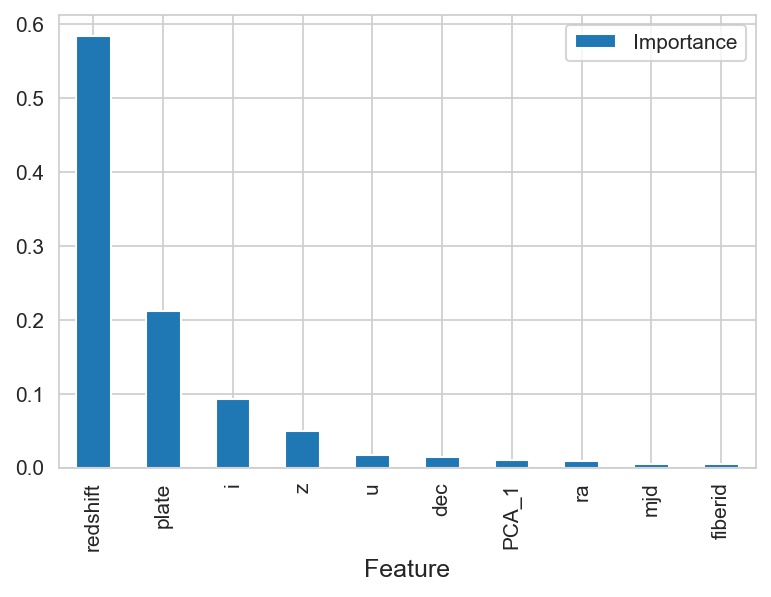

In [143]:
importances.plot.bar()

Here we can clearly see how PCA helped to improve the performance of our predictors as 3 of the principal components are in the top 4 features.

The best (in terms of being able to split classes) is redshift.

Mjd is the feature with the lowest importance during the classification process, we will therefore drop it from the dataframe.

Let's drop the column from the dataframe and rescale it. Since XGBoost requires the class to be discrete, we will re-add it manually afterwards.

In [151]:
scaler = MinMaxScaler()
sdss = pd.DataFrame(scaler.fit_transform(sdss_df_fe.drop(['mjd', 'class','fiberid','ra','dec','PCA_1'], axis=1)), columns=sdss_df_fe.drop(['PCA_1','ra','dec','mjd', 'class','fiberid'], axis=1).columns)
sdss['class'] = sdss_df_fe['class']

In [152]:
sdss.head()

,u,i,z,redshift,plate,class
0,0.963976,0.449996,0.422654,0.376270,0.314366,1
1,0.944694,0.381433,0.363705,0.022133,0.003512,0
2,0.851241,0.375563,0.368103,0.000590,0.618634,2
3,0.871877,0.450061,0.434631,0.111427,0.016421,1
4,0.938204,0.392733,0.370091,0.374240,0.045223,1


### Summary

We trained different machine learning models to solve this classification problems. Without any further hyperparameter tuning XGBoost and Scikit-Learn's Random Forest Classifier performed the best.

As XGBoost showed a little higher accuracy in most of the tests, we will continue only with this classifier.

## XGBoost - Evaluation

### Confusion Matrix

In [154]:
unique, counts = np.unique(sdss['class'], return_counts=True)
dict(zip(unique, counts))

{0: 10000, 1: 10000, 2: 10000}

In [155]:
predictions = cross_val_predict(xgb, sdss.drop('class', axis=1), sdss['class'], cv=3)
confusion_matrix(sdss['class'], predictions)

array([[9860,  126,   14],
       [ 277, 9720,    3],
       [   6,    2, 9992]], dtype=int64)

The first row shows that out of 4998 stars, **4962 were classified correctly as stars**. 29 stars were classified incorrectly as galaxies and 7 stars were classified incorrectly as quasars.

The second row shows out of 850 quasars **827 were classified correctly**. 22 qsos were classified incorrectly as stars and 1 quasar was classified as galaxy.

The last row tells us that out of 4152 galaxies **4147 were classified correctly.**. 5 galaxies were classified incorrectly as star.

In total: 

We have only 64 objects which were classified incorrectly. Most of the objects were recognized as what they are.

### Precision & Recall

In [156]:
print("Precision:", precision_score(sdss['class'], predictions, average='micro'))
print("Recall:",recall_score(sdss['class'], predictions, average='micro'))

Precision: 0.9857333333333334
Recall: 0.9857333333333334


Precision is the fraction of events where the algorithm classified an object of type **t** correctly out of all occurences of the algorithm classifying objects of type **t**.

Recall is the fraction of events where the algorithm classified an object of type **t** correctly when the true type of that object was actually **t**.

Precision in our case:

For every class its calculated how many objects were classified as stars (or galaxies or quasars) in relation to the amount of correct star (or galaxies or quasars) predictions. The results are averaged --> 98.86%.

Recall in our case:

For every class its calculated how many objects were classified as stars (or galaxies or quasars) in relation to the total amount of predictions where the object actually was a star (or galaxy or quasar). The results are averaged --> 98.86%.


### F1-Score

One can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

In [157]:
print("F1-Score:", f1_score(sdss['class'], predictions, average='micro'))

F1-Score: 0.9857333333333334
